In [66]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [67]:
dailyData = pd.read_csv("train.csv")

# **EDA**

## **1. Convert datatime to categorical variables**

In [68]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])

In [69]:
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])

In [70]:
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])

In [71]:
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])

In [72]:
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })

In [73]:
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [74]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

In [75]:
dailyData  = dailyData.drop(["datetime"],axis=1)

In [86]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={'index': 'variableType'})

In [93]:
dataTypeDf['typeName'] = dataTypeDf['variableType'].apply(lambda x: x.name)
dataTypeDf = dataTypeDf.drop('variableType', axis=1)
dataTypeDf = dataTypeDf.groupby('typeName')['count'].sum().reset_index(name='count')

[Text(0.5, 0, 'variableTypeariable Type'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Variables DataType Count')]

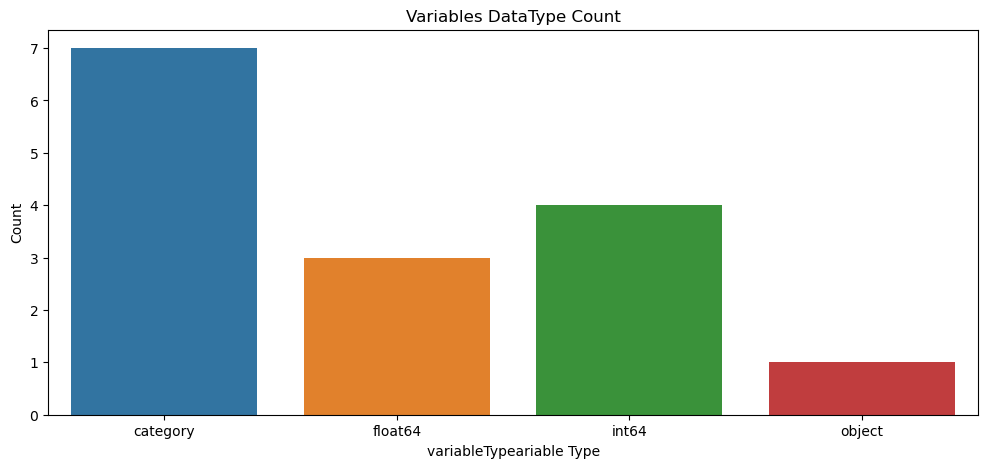

In [95]:
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=dataTypeDf,x="typeName",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

## **2. Missing Values**

In [99]:
dailyData.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
date          0
hour          0
weekday       0
month         0
dtype: int64

<Axes: >

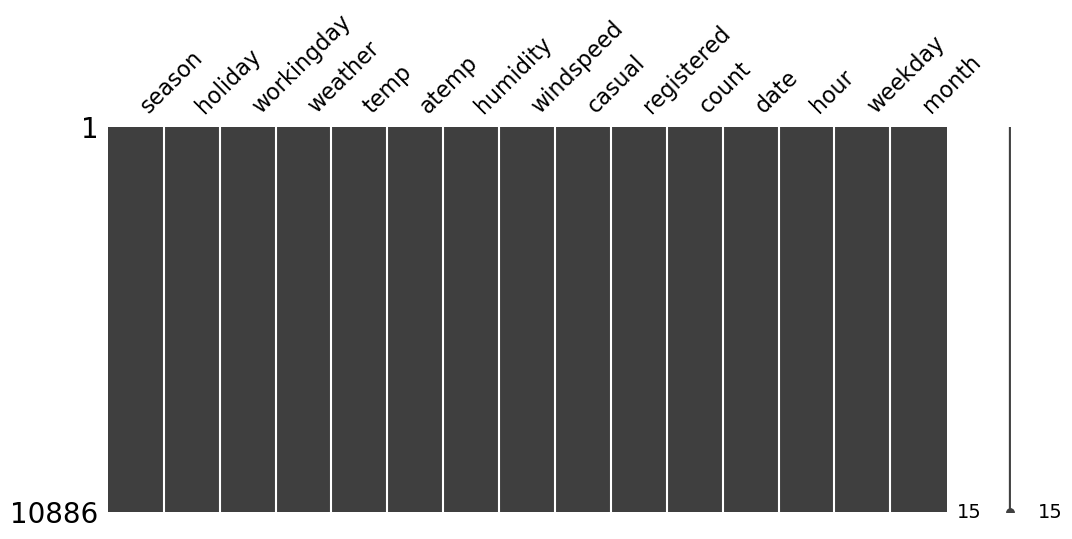

In [100]:
msno.matrix(dailyData,figsize=(12,5))

## **3. Outliers**

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

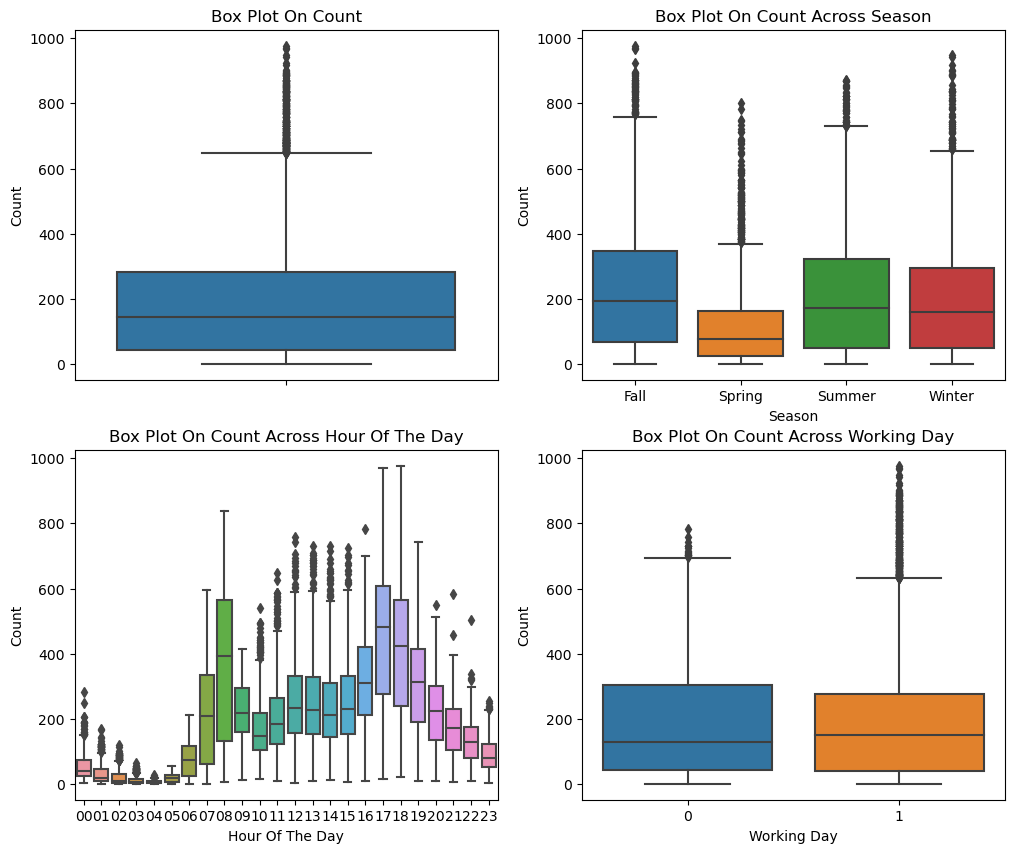

In [101]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

1. (Top left) Many outliers skew the distribution to the right
2. (Top right) Spring has lower counts
3. (Lower left) The hours with highest counts are 8am, 17pm, 18pm. 
4. (Lower right) Most outliers are from Working Day.

In [102]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 

In [103]:
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


## **4. Correlation**

<Axes: >

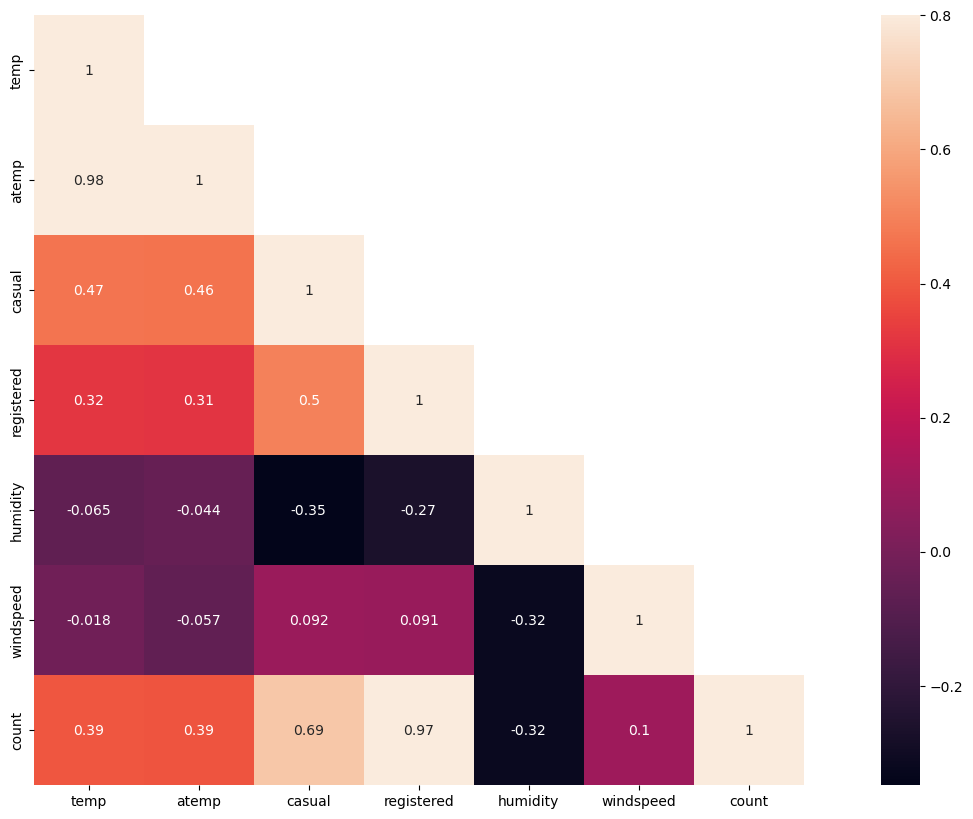

In [116]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = 0
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt,mask=mask, vmax=.8, square=True,annot=True)

1. windspeed will not be very useful
2. temp and atemp have high correlation. Need to drop one of them.

<Axes: xlabel='humidity', ylabel='count'>

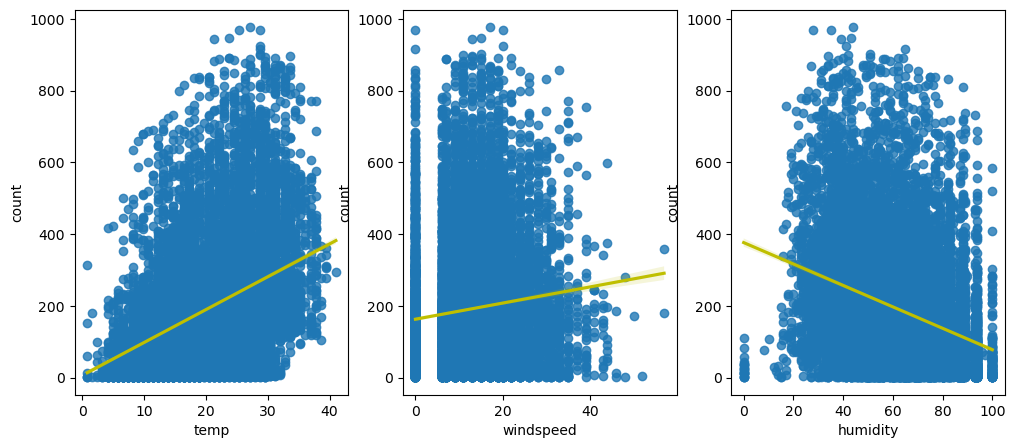

In [120]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=dailyData,ax=ax1, line_kws=dict(color='y'))
sn.regplot(x="windspeed", y="count", data=dailyData,ax=ax2, line_kws=dict(color='y'))
sn.regplot(x="humidity", y="count", data=dailyData,ax=ax3, line_kws=dict(color='y'))

## **5. Transformation**

We saw above that count is right skewed. We apply a log transform to mitigate this.

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229772, 4.562423868087808, 0.958117678090961))

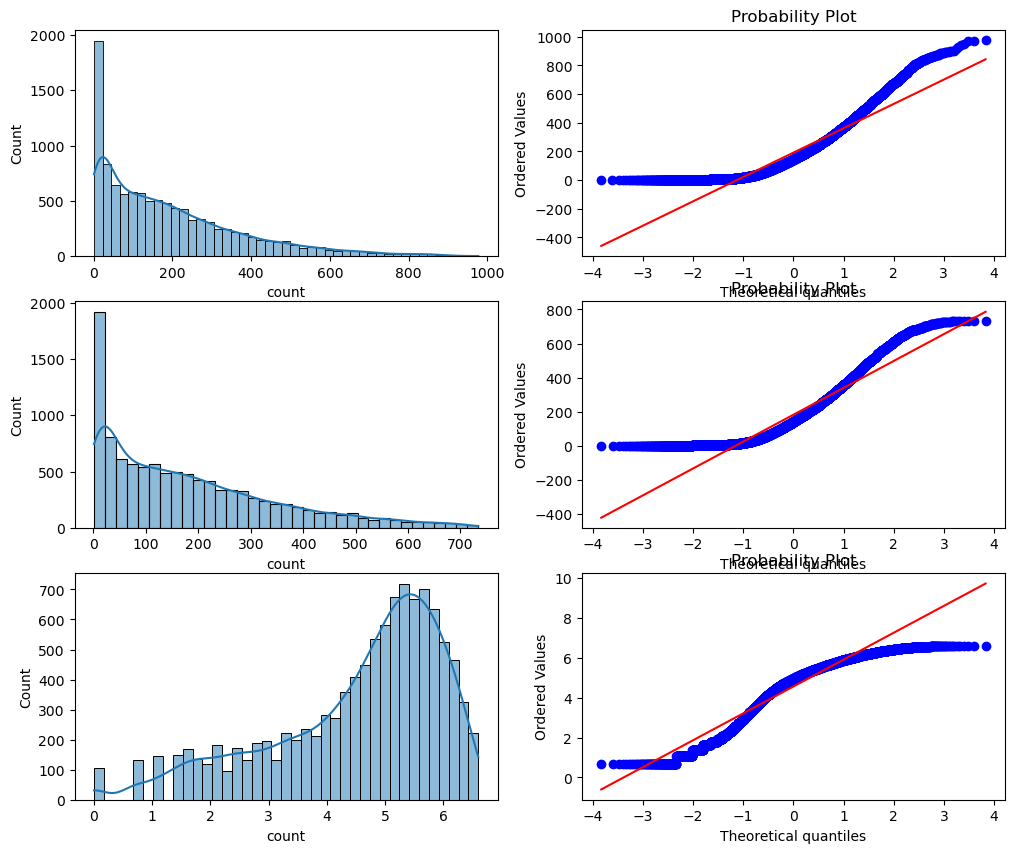

In [125]:
fig,axes = plt.subplots(ncols=2,nrows=3)
fig.set_size_inches(12, 10)
sn.histplot(dailyData["count"],ax=axes[0][0], kde=True)
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])
sn.histplot(dailyDataWithoutOutliers["count"],ax=axes[1][0], kde=True)
stats.probplot(dailyDataWithoutOutliers["count"], dist='norm', fit=True, plot=axes[1][1])
sn.histplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[2][0], kde=True)
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[2][1])

## **6. Visualization**

**6.1 month vs count**

[Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Avearage Count'),
 Text(0.5, 1.0, 'Average Count By Month')]

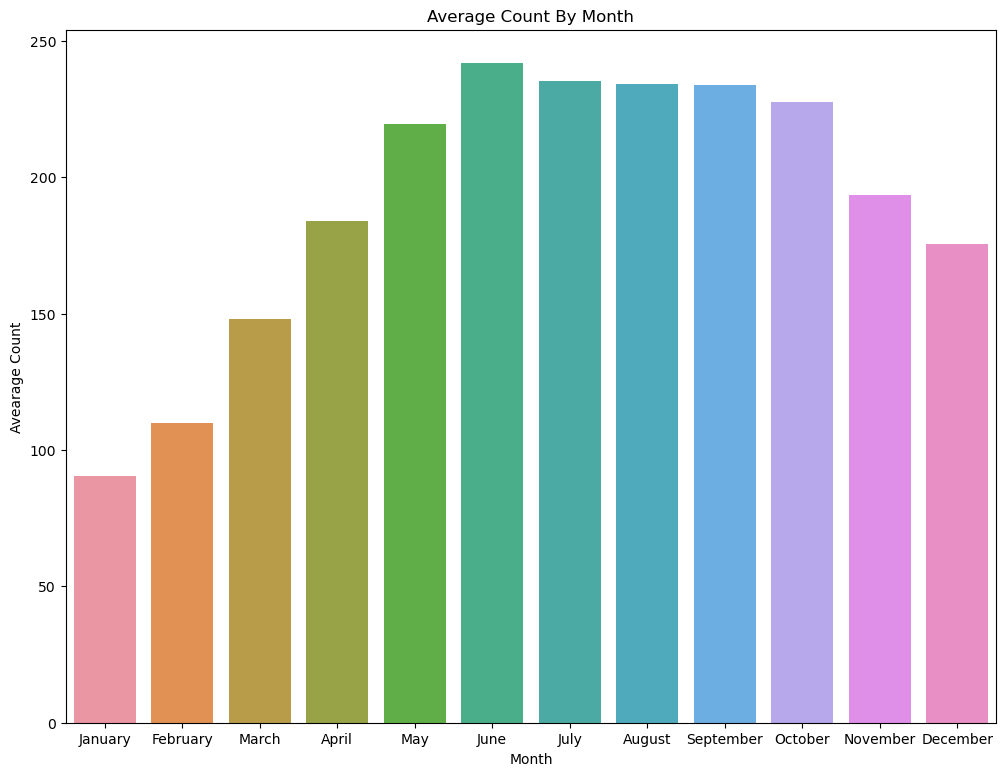

In [141]:
fig,ax= plt.subplots()
fig.set_size_inches(12,9)

# month vs count
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax,order=sortOrder)
ax.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")


We see that the count is higher during the summer months.

**6.2 hour vs count, group by season**

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Season'),
 None]

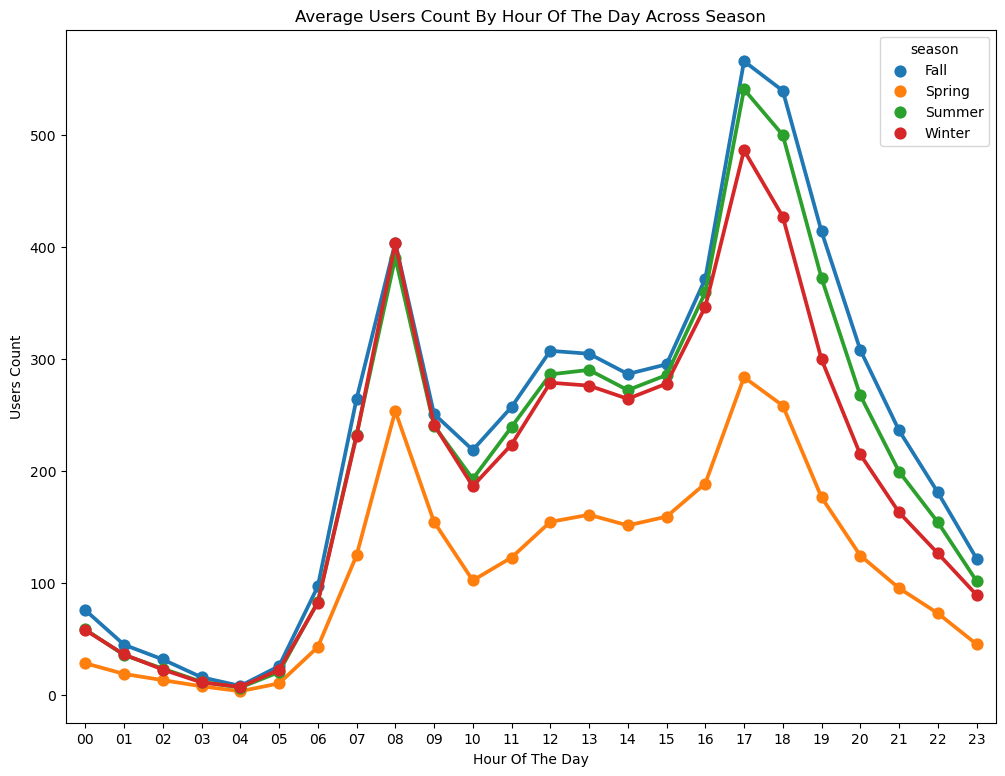

In [142]:
fig,ax= plt.subplots()
fig.set_size_inches(12,9)


hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')


1. The count is highest around 7am - 8am and 17pm - 18pm for all seasons. 
2. The count is lower in spring.

**6.2 hour vs count, group by weekday**

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Weekdays'),
 None]

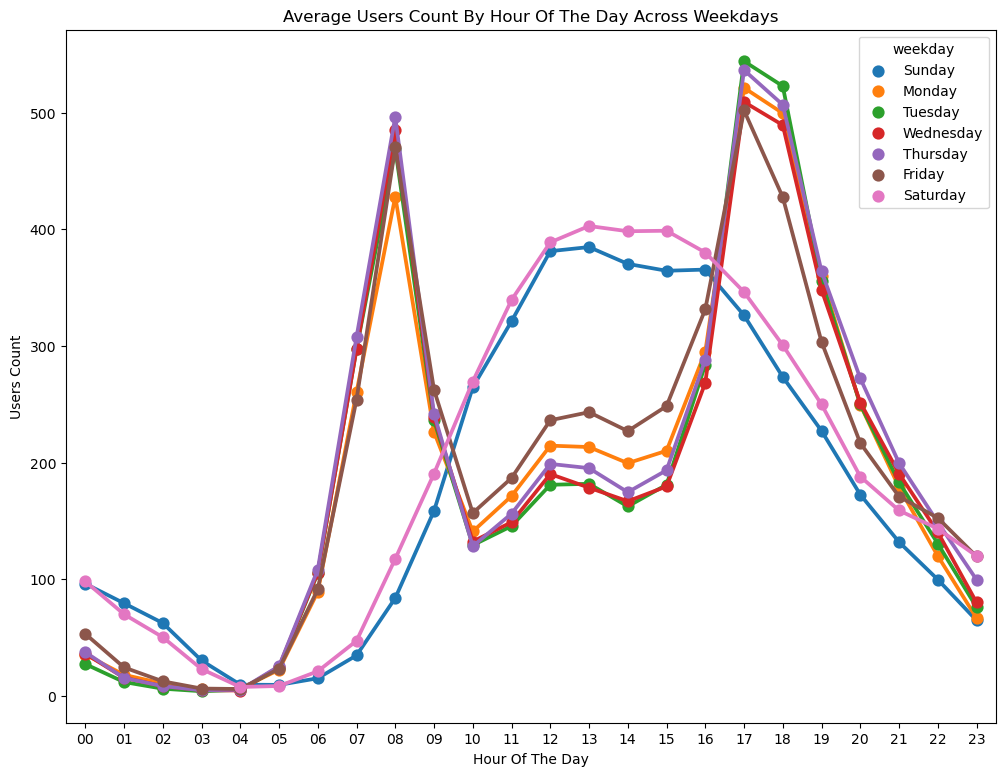

In [143]:
fig,ax= plt.subplots()
fig.set_size_inches(12,9)

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

1. The trends are different for weekdays and weekend, within each of which the difference is small. 
2. On weekdays, the count is highest around 7am and 17pm.
3. On the weekend, the count is highest around 14pm.

**6.2 hour vs count, group by user type**

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

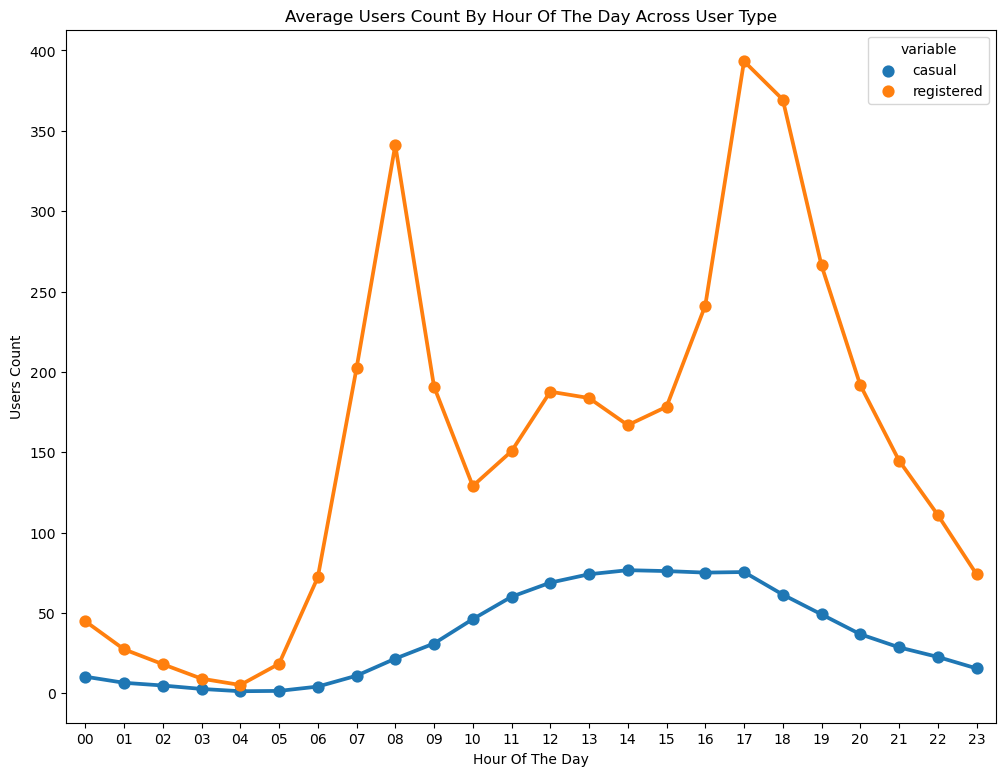

In [144]:
fig,ax= plt.subplots()
fig.set_size_inches(12,9)

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourTransformed
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

Comparing this with the trends when we were grouping by weekdays, counts from registered users behave similarly to counts on the weekdays. Counts from casual users have a similar trend to the counts on the weekend. 

# Models

**Preparation**

In [160]:
dataTrain = pd.read_csv("train.csv")
dataTest = pd.read_csv("test.csv")

In [161]:
data = pd.concat([dataTrain, dataTest], ignore_index=True)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

**Feature engineering for datetime** 

In [162]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

## 1. Filling 0's in windspeed using random forest

In [163]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
print(dataWind0.tail(2))
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = pd.concat([dataWindNot0, dataWind0], ignore_index=True)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

In [164]:
dataWind0.tail(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
17330,2012-12-29 23:00:00,1,0,0,2,10.66,12.12,60,25.181343,NaN,NaN,NaN,2012-12-29,23,2012,5,12
17350,2012-12-30 19:00:00,1,0,0,1,13.94,18.18,61,7.107947,NaN,NaN,NaN,2012-12-30,19,2012,6,12
